# Model Training - MobileNetV2 (transfer + data augmentation) balanced

### 0. Imports

In [19]:
import numpy as np

from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau
)
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.metrics import Accuracy, CategoricalAccuracy, Precision, Recall
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from sklearn.utils.class_weight import compute_class_weight

### 1. Paths

In [20]:
# DATASET_BASE_TRAIN_PATH = "/Users/adamdabkowski/DataspellProjects/Praca_dyplomowa/data/train_resized"
# DATASET_BASE_TRAIN_PATH = "/Users/adamd/DataspellProjects/Facial Expressions Recognition/data/train_resized"
# DATASET_BASE_TRAIN_PATH = "/Users/adamd/DataspellProjects/Facial Expressions Recognition/data/train_merged"
DATASET_BASE_TRAIN_PATH = "/Users/adamd/DataspellProjects/Facial Expressions Recognition/data/train_merged_cleaned"

# DATASET_BASE_TRAIN_PATH = "../new_data"

# DATASET_BASE_TEST_PATH = "/Users/adamdabkowski/DataspellProjects/Praca_dyplomowa/data/test_resized"
DATASET_BASE_TEST_PATH = "/Users/adamd/DataspellProjects/Facial Expressions Recognition/data/test_resized"

### 2. Data preprocessing

In [3]:
batch_size  = 32
img_size = 224

train_validation_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_validation_data_generator.flow_from_directory(
    DATASET_BASE_TRAIN_PATH,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='training',
    shuffle=True,
)

validation_generator = train_validation_data_generator.flow_from_directory(
    DATASET_BASE_TRAIN_PATH,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation',
    shuffle=True,
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

Found 23689 images belonging to 7 classes.
Found 5919 images belonging to 7 classes.


In [4]:
class_weights_dict

{0: 1.0264309545474242,
 1: 6.701272984441301,
 2: 1.0027089947089947,
 3: 0.5746549256483031,
 4: 0.8318935243714005,
 5: 0.8679514893928846,
 6: 1.2741501721170396}

### 5. Model creating

In [7]:
CATEGORIES = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

In [9]:
checkpoint = ModelCheckpoint(
    filepath="./model_mobilenet_v2_transfer_data_augmentation_balanced.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=0.00001,
)

callbacks_list = [early_stopping, checkpoint, reduce_learning_rate]

In [10]:
model = Sequential()

base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
model.add(base_model)

model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [11]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        "accuracy",
        "categorical_accuracy",
        Precision(name='precision'),
        Precision(class_id=0, name='precision_angry'),
        Precision(class_id=1, name='precision_disgust'),
        Precision(class_id=2, name='precision_fear'),
        Precision(class_id=3, name='precision_happy'),
        Precision(class_id=4, name='precision_neutral'),
        Precision(class_id=5, name='precision_sad'),
        Precision(class_id=6, name='precision_surprise'),
        Recall(name='recall'),
        Recall(class_id=0, name='recall_angry'),
        Recall(class_id=1, name='recall_disgust'),
        Recall(class_id=2, name='recall_fear'),
        Recall(class_id=3, name='recall_happy'),
        Recall(class_id=4, name='recall_neutral'),
        Recall(class_id=5, name='recall_sad'),
        Recall(class_id=6, name='recall_surprise'),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 2,917,447
Trainable params: 2,883,335
Non-trainable params: 34,112
_________________________________________________________________


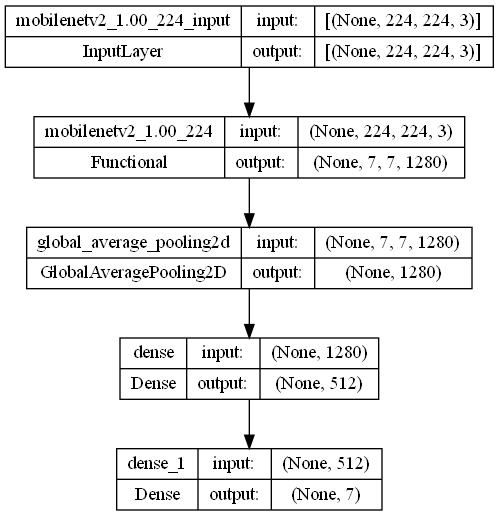

In [14]:
plot_model(model, to_file='model_mobilenet_v2_transfer_data_augmentation_balanced.png', show_shapes=True, show_layer_names=True)

### 6. Model training

In [13]:
epochs = 50

In [15]:
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n//validation_generator.batch_size,
    callbacks=callbacks_list,
    class_weight=class_weights_dict,
)

Epoch 1/50
740/740 [==============================] - ETA: 0s - loss: 1.7263 - accuracy: 0.3332 - categorical_accuracy: 0.3332 - precision: 0.5882 - precision_angry: 0.3148 - precision_disgust: 0.1383 - precision_fear: 0.2941 - precision_happy: 0.7914 - precision_neutral: 0.4800 - precision_sad: 0.3415 - precision_surprise: 0.5543 - recall: 0.1024 - recall_angry: 0.0052 - recall_disgust: 0.1366 - recall_fear: 0.0030 - recall_happy: 0.2221 - recall_neutral: 0.0207 - recall_sad: 0.0036 - recall_surprise: 0.3483
Epoch 1: val_loss improved from inf to 4.90541, saving model to .\model_mobilenet_v2_transfer_data_augmentation_balanced.h5
740/740 [==============================] - 1110s 1s/step - loss: 1.7263 - accuracy: 0.3332 - categorical_accuracy: 0.3332 - precision: 0.5882 - precision_angry: 0.3148 - precision_disgust: 0.1383 - precision_fear: 0.2941 - precision_happy: 0.7914 - precision_neutral: 0.4800 - precision_sad: 0.3415 - precision_surprise: 0.5543 - recall: 0.1024 - recall_angry: 

### 7. Evaluation - Test set

In [21]:
from keras.models import load_model

model = load_model("model_mobilenet_v2_transfer_data_augmentation_balanced.h5")

In [22]:
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_data_generator.flow_from_directory(
    DATASET_BASE_TEST_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 7178 images belonging to 7 classes.


In [23]:
model.evaluate(test_generator)

225/225 [==============================] - 136s 386ms/step - loss: 0.9307 - accuracy: 0.6617 - categorical_accuracy: 0.6617 - precision: 0.7475 - precision_angry: 0.6385 - precision_disgust: 0.5889 - precision_fear: 0.6675 - precision_happy: 0.9198 - precision_neutral: 0.6434 - precision_sad: 0.6517 - precision_surprise: 0.7912 - recall: 0.5836 - recall_angry: 0.5292 - recall_disgust: 0.4775 - recall_fear: 0.2646 - recall_happy: 0.8472 - recall_neutral: 0.5750 - recall_sad: 0.3841 - recall_surprise: 0.8026


[0.9307246804237366,
 0.661744236946106,
 0.661744236946106,
 0.747501790523529,
 0.6385390162467957,
 0.5888888835906982,
 0.6674876809120178,
 0.9198286533355713,
 0.6433756947517395,
 0.6517006754875183,
 0.7912217974662781,
 0.583588719367981,
 0.5292275547981262,
 0.477477490901947,
 0.2646484375,
 0.8472378849983215,
 0.5750202536582947,
 0.3841218948364258,
 0.8026474118232727]